In [406]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_mask_hsv(img, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def extract_yellow_card_mask(img):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    return extract_mask_hsv(img, lower_yellow, upper_yellow)

def extract_white_card_mask(img):
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    return extract_mask_hsv(img, lower_white, upper_white)

def extract_black_card_mask(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    return extract_mask_hsv(img, lower_black, upper_black)

def extract_red_card_mask(img):
    lower_red1 = np.array([0, 100, 20])
    upper_red1 = np.array([5, 255, 255])
    return extract_mask_hsv(img, lower_red1, upper_red1)


def compute_patch_means(lab_img, patch_mask):
    patch_pixels = lab_img[patch_mask > 0]
    if patch_pixels.size == 0:
        return None
    L = patch_pixels[:,0]
    A = patch_pixels[:,1]
    B = patch_pixels[:,2]
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color_multicard(full_img, yellow_mask, white_mask, black_mask, red_mask,
                                  target_lab_yellow, target_lab_white, target_lab_black, target_lab_red):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)

    yellow_means = compute_patch_means(lab_full, yellow_mask)
    white_means = compute_patch_means(lab_full, white_mask)
    black_means = compute_patch_means(lab_full, black_mask)
    red_means = compute_patch_means(lab_full, red_mask)

    if None in (yellow_means, white_means, black_means, red_means):
        print("One or more patches not detected properly. Skipping correction.")
        return full_img

    L_y, A_y, B_y = yellow_means
    L_w, A_w, B_w = white_means
    L_b, A_b, B_b = black_means
    L_r, A_r, B_r = red_means

    delta_L = np.mean([target_lab_yellow[0] - L_y,
                       target_lab_white[0] - L_w,
                       target_lab_black[0] - L_b,
                       target_lab_red[0] - L_r])
    delta_A = np.mean([target_lab_yellow[1] - A_y,
                       target_lab_white[1] - A_w,
                       target_lab_black[1] - A_b,
                       target_lab_red[1] - A_r])
    delta_B = np.mean([target_lab_yellow[2] - B_y,
                       target_lab_white[2] - B_w,
                       target_lab_black[2] - B_b,
                       target_lab_red[2] - B_r])

    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)

    return corrected_bgr


In [437]:
import cv2
import numpy as np
bgr = [255, 0, 0]
lab = cv2.cvtColor( np.uint8([[bgr]] ), cv2.COLOR_BGR2LAB)[0][0]
print(lab)  

[ 82 207  20]


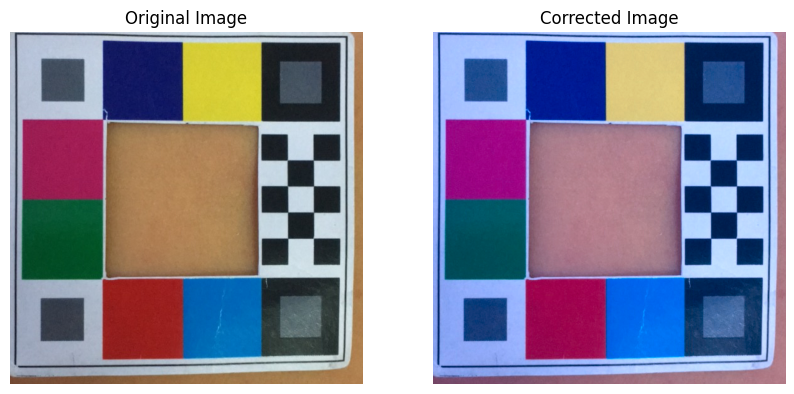

In [438]:
img = image_data[1376]


target_lab_yellow = (207.0, 121.0, 209.0)
target_lab_white = (255.0, 128.0, 128.0)
target_lab_black = (0.0, 128.0, 128.0)
target_lab_red = (82.0, 207.0, 20.0)  


yellow_mask = extract_yellow_card_mask(img)
white_mask = extract_white_card_mask(img)
black_mask = extract_black_card_mask(img)
red_mask = extract_red_card_mask(img)

corrected_img = correct_image_color_multicard(
    img, yellow_mask, white_mask, black_mask, red_mask,
    target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
plt.title("Corrected Image")
plt.axis('off')

plt.show()


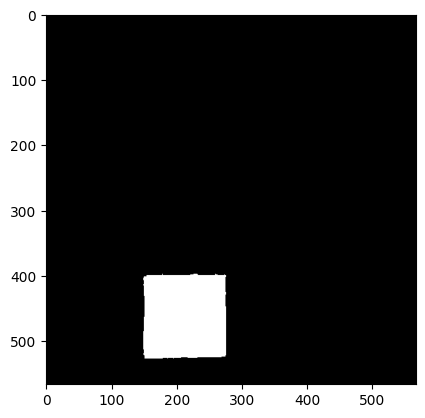

In [439]:
plt.imshow(cv2.cvtColor(red_mask, cv2.COLOR_BGR2RGB))

In [440]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


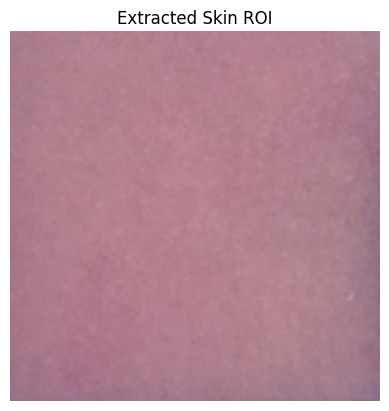

In [441]:
skin_roi = extract_skin_roi(corrected_img)

plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [442]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [445]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    target_lab_yellow = (207.0, 121.0, 209.0)
    target_lab_white = (255.0, 128.0, 128.0)
    target_lab_black = (0.0, 128.0, 128.0)
    target_lab_red = (82.0, 207.0, 20.0)  


    yellow_mask = extract_yellow_card_mask(img)
    white_mask = extract_white_card_mask(img)
    black_mask = extract_black_card_mask(img)
    red_mask = extract_red_card_mask(img)

    corrected_img = correct_image_color_multicard(
        img, yellow_mask, white_mask, black_mask, red_mask,
        target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
    )

    skin_roi = extract_skin_roi(corrected_img)
    return extract_color_spaces(skin_roi)


In [415]:
skin_roi.shape

(198, 198, 3)

In [446]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)


One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properl

In [447]:
import numpy as np
color=processed_rgb[588]
mean = color.mean(axis=0)
median = np.median(color, axis=0)
std_dev = color.std(axis=0)
min_val = color.min(axis=0)
max_val = color.max(axis=0)

stats = {
    "Channel": ["R", "G", "B"],
    "Mean": mean,
    "Median": median,
    "Std Dev": std_dev,
    "Min": min_val,
    "Max": max_val
}
for i, channel in enumerate(stats["Channel"]):
    print(f"{channel} channel:")
    print(f"  Mean     : {mean[i]:.2f}")
    print(f"  Median   : {median[i]}")
    print(f"  Std Dev  : {std_dev[i]:.2f}")
    print(f"  Min      : {min_val[i]}")
    print(f"  Max      : {max_val[i]}")
    print()
print(labels[588])


R channel:
  Mean     : 125.88
  Median   : 122.0
  Std Dev  : 13.77
  Min      : 95
  Max      : 166

G channel:
  Mean     : 164.46
  Median   : 165.0
  Std Dev  : 1.89
  Min      : 156
  Max      : 171

B channel:
  Mean     : 117.87
  Median   : 118.0
  Std Dev  : 2.79
  Min      : 108
  Max      : 124

7.0


In [448]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)

print(rgb_scaled.shape)


(2235, 3, 16384)


In [449]:
from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    rgb_scaled, hsv_scaled, ycbcr_scaled, lab_scaled, processed_labels, test_size=0.3, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.67, random_state=42)

In [450]:
print(processed_rgb.shape)
print(rgb_scaled.shape)
print(rgb_flat_scaled.shape)

(2235, 16384, 3)
(2235, 3, 16384)
(2235, 49152)


In [451]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

def conv_branch(input_tensor):
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    return x

def build_rgb_hsv_concat_model(input_shape):
    rgb_input = Input(shape=input_shape, name='rgb_input')
    rgb_features = conv_branch(rgb_input)
    hsv_input = Input(shape=input_shape, name='hsv_input')
    hsv_features = conv_branch(hsv_input)

    combined = Concatenate()([rgb_features, hsv_features])
    
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[rgb_input, hsv_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

input_shape = rgb_train.shape[1:]  
model = build_rgb_hsv_concat_model(input_shape)
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 conv1d_64 (Conv1D)          (None, 3, 32)                1572896   ['rgb_input[0][0]']           
                                                                                                  
 conv1d_68 (Conv1D)          (None, 3, 32)                1572896   ['hsv_input[0][0]']           
                                                                                            

In [452]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=2)
]

history = model.fit(
    [rgb_train, hsv_train], y_train,
    validation_data=([rgb_val, hsv_val], y_val),
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/150
49/49 [==============================] - 8s 72ms/step - loss: 66.1762 - mae: 6.7058 - val_loss: 32.7721 - val_mae: 4.9264 - lr: 1.0000e-04
Epoch 2/150
49/49 [==============================] - 3s 69ms/step - loss: 35.0053 - mae: 4.9055 - val_loss: 27.5736 - val_mae: 4.4075 - lr: 1.0000e-04
Epoch 3/150
49/49 [==============================] - 3s 56ms/step - loss: 30.2264 - mae: 4.5348 - val_loss: 21.2577 - val_mae: 3.8873 - lr: 1.0000e-04
Epoch 4/150
49/49 [==============================] - 3s 53ms/step - loss: 23.6079 - mae: 3.9654 - val_loss: 14.5147 - val_mae: 3.1162 - lr: 1.0000e-04
Epoch 5/150
49/49 [==============================] - 3s 61ms/step - loss: 19.7286 - mae: 3.5042 - val_loss: 14.1204 - val_mae: 2.9936 - lr: 1.0000e-04
Epoch 6/150
49/49 [==============================] - 3s 61ms/step - loss: 17.3172 - mae: 3.3085 - val_loss: 11.5942 - val_mae: 2.6898 - lr: 1.0000e-04
Epoch 7/150
49/49 [==============================] - 3s 61ms/step - loss: 17.2979 - mae: 3.218

In [453]:
test_loss, test_mae = model.evaluate([rgb_test, hsv_test], y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict([rgb_test, hsv_test])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")



15/15 - 0s - loss: 10.2489 - mae: 2.4690 - 162ms/epoch - 11ms/step
Test Loss (MSE): 10.2489
Test MAE: 2.4690
15/15 [==============================] - 0s 8ms/step
RMSE: 3.201
R²: 0.639


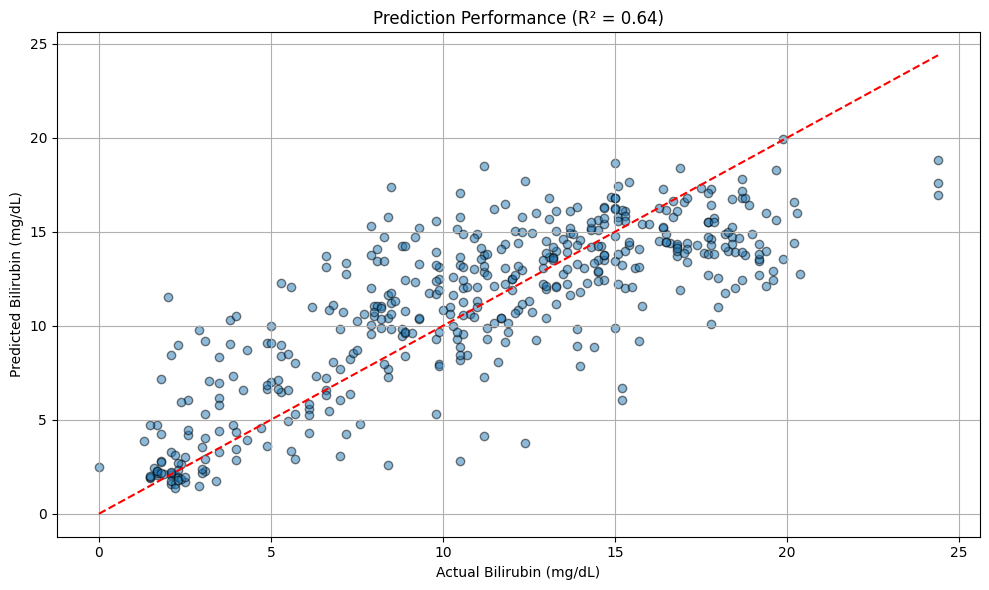

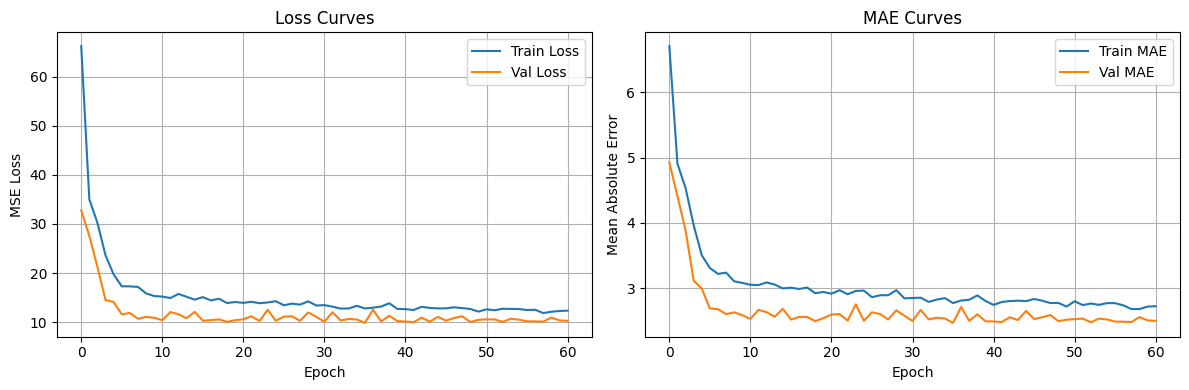

In [454]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distribution of test')

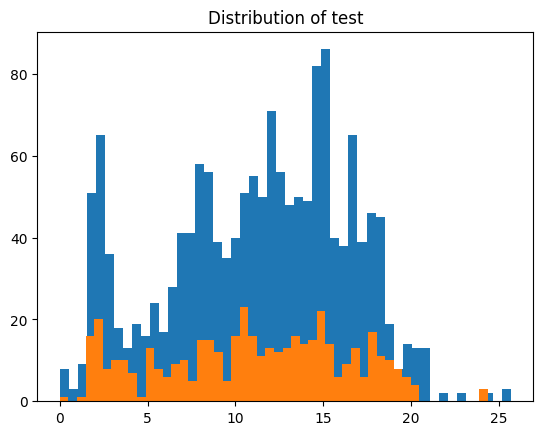

In [455]:
import matplotlib.pyplot as plt
plt.hist(y_train.flatten(), bins=50)
plt.title("Distribution of train")

plt.hist(y_test.flatten(), bins=50)
plt.title("Distribution of test")


In [426]:
import numpy as np

def count_ranges(y_data, data_name):
    y_array = np.array(y_data)
    
    count_0_5 = np.sum((y_array >= 0) & (y_array < 5))
    count_5_10 = np.sum((y_array >= 5) & (y_array <= 10))
    count_above_10 = np.sum(y_array > 10)
    
    total = len(y_array)
    if total > 0:
        perc_0_5 = (count_0_5 / total) * 100
        perc_5_10 = (count_5_10 / total) * 100
        perc_above_10 = (count_above_10 / total) * 100
    else:
        perc_0_5 = perc_5_10 = perc_above_10 = 0
    
    print(f"\n{data_name} (Total: {total})")
    print(f"0-5 mg/dL: {count_0_5} ({perc_0_5:.2f}%)")
    print(f"5-10 mg/dL: {count_5_10} ({perc_5_10:.2f}%)")
    print(f">10 mg/dL: {count_above_10} ({perc_above_10:.2f}%)")

count_ranges(y_train, "Training set")
count_ranges(y_val, "Validation set")
count_ranges(y_test, "Test set")


Training set (Total: 1564)
0-5 mg/dL: 232 (14.83%)
5-10 mg/dL: 376 (24.04%)
>10 mg/dL: 956 (61.13%)

Validation set (Total: 221)
0-5 mg/dL: 35 (15.84%)
5-10 mg/dL: 47 (21.27%)
>10 mg/dL: 139 (62.90%)

Test set (Total: 450)
0-5 mg/dL: 78 (17.33%)
5-10 mg/dL: 108 (24.00%)
>10 mg/dL: 264 (58.67%)
